In [2]:
import muon as mu
import deconvatac as decon
import os
import scanpy as sc

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [3]:
data_path = '/vol/storage/data/Russell/Russell_melanoma.h5mu'

In [4]:
mdata = mu.read(data_path)

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [5]:
adata = mdata['atac']

In [6]:
adata

AnnData object with n_obs × n_vars = 2535 × 53451
    obs: 'barcodes', 'NAME_x', 'X', 'Y', 'cell_type', 'NAME_y', 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'cluster'
    var: 'features'
    uns: 'cell_type_colors'
    obsm: 'X_umap', 'spatial'

In [7]:
# reads to fragments
decon.pp.reads_to_fragments(adata)

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


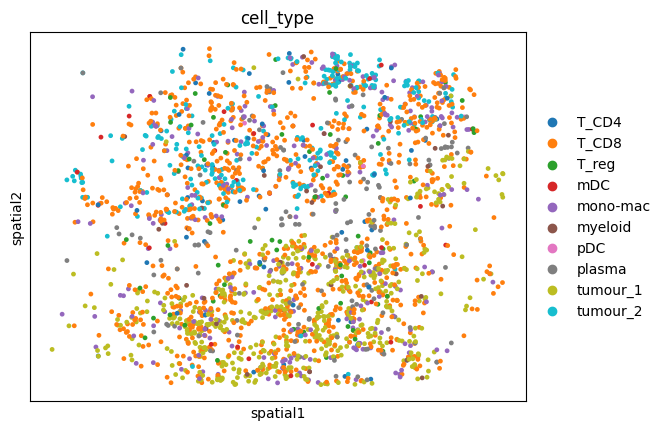

In [8]:
sc.pl.embedding(adata, basis='spatial', color='cell_type')

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


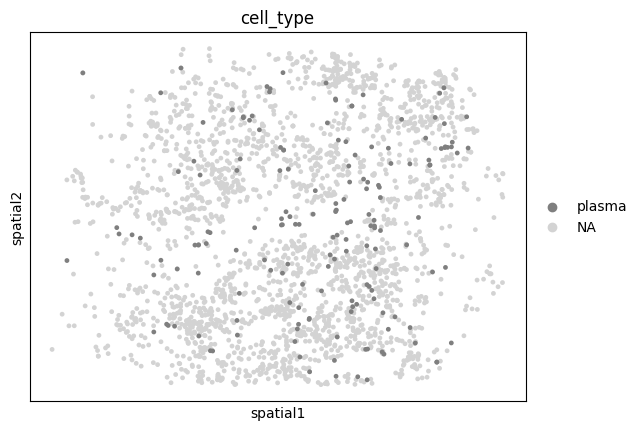

In [15]:
sc.pl.embedding(adata, basis='spatial', color='cell_type', groups='plasma')

## Simulate Visium data

In [16]:
# from https://github.com/QuKunLab/SpatialBenchmarking/blob/main/SimulatedData.ipynb
import numpy as np
import pandas as pd
import os
import scipy

def Simulated(adata, window, layer=None):
    combined_spot = []
    combined_spot_loc = []

    spatial_loc = pd.DataFrame(adata.obsm['spatial'], index=adata.obs_names, columns=['x','y'])
    for x in np.arange((spatial_loc['x'].min()//window),spatial_loc['x'].max()//window+1):
        for y in np.arange((spatial_loc['y'].min()//window),spatial_loc['y'].max()//window+1):
            tmp_loc = spatial_loc[(x*window < spatial_loc['x']) & (spatial_loc['x'] < (x+1)*window) &\
                                   (y*window < spatial_loc['y']) & (spatial_loc['y'] < (y+1)*window)]
            if len(tmp_loc) > 0:
                combined_spot_loc.append([x,y])
                combined_spot.append(tmp_loc.index.to_list())

    combined_cell_counts = pd.DataFrame([len(s) for s in combined_spot],columns=['cell_count'])
    combined_spot_loc = pd.DataFrame(combined_spot_loc, columns=['x','y'])

    combined_spot_exp = []
    for s in combined_spot:
        if layer is None:
            combined_spot_exp.append(adata[s,:].X.sum(axis=0))
        else:
            combined_spot_exp.append(adata[s,:].layers[layer].sum(axis=0))

    combined_spot_exp = np.concatenate(combined_spot_exp, axis=0).reshape(len(combined_spot),-1)

    combined_spot_clusters = pd.DataFrame(np.zeros((len(combined_spot_loc.index),len(np.unique(adata.obs['cell_type'])))), columns=np.unique(adata.obs['cell_type']))
    for i,c in enumerate(combined_spot):
        for clt in adata[c, :].obs['cell_type']:
            combined_spot_clusters.loc[i,clt] += 1


    adata_st = sc.AnnData(
        scipy.sparse.csr_matrix(combined_spot_exp), 
        obs=combined_cell_counts, 
        var=adata.var, 
        obsm={'proportions': (combined_spot_clusters/combined_cell_counts.values).values, 'spatial': combined_spot_loc.values}, 
        uns={'proportion_names': combined_spot_clusters.columns.to_list()}
        )
    return adata_st

In [41]:
combined_spot = []

window = 250
spatial_loc = pd.DataFrame(adata.obsm["spatial"], index=adata.obs_names, columns=["x", "y"])
for x in np.arange((spatial_loc["x"].min() // window), spatial_loc["x"].max() // window + 1):
    for y in np.arange((spatial_loc["y"].min() // window), spatial_loc["y"].max() // window + 1):
        tmp_loc = spatial_loc[
            (x * window < spatial_loc["x"])
            & (spatial_loc["x"] < (x + 1) * window)
            & (y * window < spatial_loc["y"])
            & (spatial_loc["y"] < (y + 1) * window)
        ]
        if len(tmp_loc) > 0:
            combined_spot.append(tmp_loc.index.to_list())

combined_cell_counts = pd.DataFrame([len(s) for s in combined_spot], columns=["cell_count"])
np.mean(combined_cell_counts)

7.041666666666667

### ATAC

In [46]:
atac_st = Simulated(adata, 250, layer='fragments')

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### RNA

In [47]:
rna_st = Simulated(mdata['rna'], 250, layer=None)

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### Visualize the simulated data

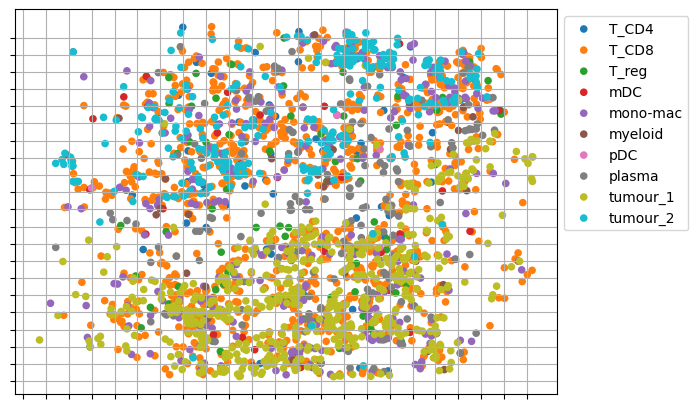

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
fig,ax = plt.subplots(figsize=(7,5))
cmap = adata.uns['cell_type_colors']
for i,c in enumerate(np.unique(adata.obs.cell_type)):
    ax.scatter(
        x=adata[adata.obs.cell_type == c, :].obsm['spatial'][:, 0],
        y=adata[adata.obs.cell_type == c, :].obsm['spatial'][:, 1],
        c=matplotlib.colors.to_hex(cmap[i]),label=c,s=30,marker='o',edgecolors='none')
ax.legend(bbox_to_anchor=(1,1))
plt.xticks(np.arange(-6000,-400,250))
plt.yticks(np.arange(-5700,-500,250))

plt.grid()
# remove xticks
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

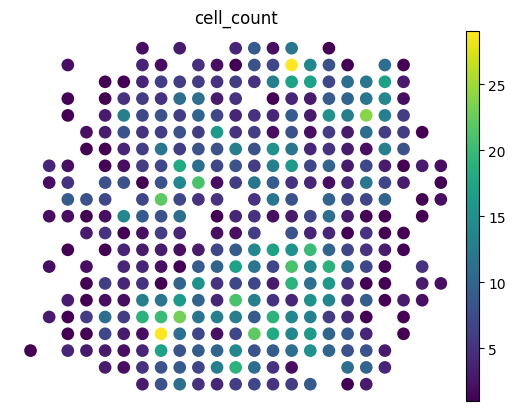

In [45]:
sc.pl.embedding(atac_st, basis='spatial', color='cell_count', frameon=False)

### Save simulated data

In [48]:
mdata_st = mu.MuData({
    "rna": rna_st,
    "atac": atac_st
}
)

In [49]:
mdata_st.write('/vol/storage/data/simulations/russell_250.h5mu')

## Save reference

In [10]:
import scipy

In [11]:
#clean up
adata_atac = sc.AnnData(X=scipy.sparse.csr_matrix(adata.layers['fragments']), obs=adata.obs, var=adata.var, obsm=adata.obsm, uns=adata.uns)

In [16]:
decon.pp.highly_variable_peaks(adata_atac, cluster_key='cell_type')

In [25]:
# get top 20000 accessible peaks
top_20000 = adata_atac.var_names[(adata_atac.X > 0).sum(axis=0).A1.argsort()[::-1][:20000]]
adata_atac.var['highly_accessible'] = adata_atac.var_names.isin(top_20000)

In [27]:
adata_rna = mdata['rna'].copy()

In [28]:
adata_rna.layers['counts'] = adata_rna.X.copy()

In [29]:
sc.pp.normalize_total(adata_rna)
sc.pp.log1p(adata_rna)

sc.pp.highly_variable_genes(adata_rna, n_top_genes=4000)

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [31]:
adata_rna.var

,ens,gene,type,chromosome,start,end,highly_variable,means,dispersions,dispersions_norm
MIR1302-2HG,ENSG00000243485,MIR1302-2HG,Gene Expression,chr1,29553,30267,False,1.000000e-12,NaN,NaN
FAM138A,ENSG00000237613,FAM138A,Gene Expression,chr1,36080,36081,False,1.000000e-12,NaN,NaN
OR4F5,ENSG00000186092,OR4F5,Gene Expression,chr1,65418,69055,False,1.544359e-04,-0.937705,-1.317582
AL627309.1,ENSG00000238009,AL627309.1,Gene Expression,chr1,120931,133723,False,3.690155e-03,-0.001166,-0.007736
AL627309.3,ENSG00000239945,AL627309.3,Gene Expression,chr1,91104,91105,False,1.000000e-12,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
AC141272.1,ENSG00000277836,AC141272.1,Gene Expression,KI270728.1,1270983,1270984,False,1.000000e-12,NaN,NaN
AC023491.2,ENSG00000278633,AC023491.2,Gene Expression,KI270731.1,13000,13001,False,1.000000e-12,NaN,NaN
AC007325.1,ENSG00000276017,AC007325.1,Gene Expression,KI270734.1,72410,72411,False,1.000000e-12,NaN,NaN
AC007325.4,ENSG00000278817,AC007325.4,Gene Expression,KI270734.1,131493,131494,True,8.562142e-03,0.730321,1.015322


In [32]:
mdata_russel = mu.MuData({
    "rna": adata_rna,
    "atac": adata_atac
}
)

In [33]:
mdata_russel.write("/vol/storage/data/simulations/russel_ref.h5mu")